In [4]:
!pip install imblearn

    100% |████████████████████████████████| 92kB 1.8MB/s ta 0:00:01
  Running setup.py bdist_wheel for imbalanced-learn ... done
  Stored in directory: /Users/adamszabunio/Library/Caches/pip/wheels/b8/20/bd/0b775f7e5d413ac72562b1a5126598bcb6e0eae10da659be9f
Successfully built imbalanced-learn


Automatically created module for IPython interactive environment


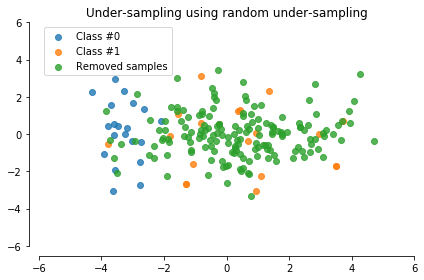

In [4]:
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

print(__doc__)

# Generate the dataset
X, y = make_classification(n_classes=2, class_sep=2, weights=[0.1, 0.9],
                           n_informative=3, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=200, random_state=10)

# Instanciate a PCA object for the sake of easy visualisation
pca = PCA(n_components=2)
# Fit and transform x to visualise inside a 2D feature space
X_vis = pca.fit_transform(X)

# Apply the random under-sampling
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X, y)
X_res_vis = pca.transform(X_resampled)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_vis.shape[0]),
                                   idx_resampled)

idx_class_0 = y_resampled == 0
plt.scatter(X_res_vis[idx_class_0, 0], X_res_vis[idx_class_0, 1],
            alpha=.8, label='Class #0')
plt.scatter(X_res_vis[~idx_class_0, 0], X_res_vis[~idx_class_0, 1],
            alpha=.8, label='Class #1')
plt.scatter(X_vis[idx_samples_removed, 0], X_vis[idx_samples_removed, 1],
            alpha=.8, label='Removed samples')

# make nice plotting
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
ax.set_xlim([-6, 6])
ax.set_ylim([-6, 6])

plt.title('Under-sampling using random under-sampling')
plt.legend()
plt.tight_layout()
plt.show()

In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np
import sklearn.metrics as sklm
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from keras.preprocessing.text import Tokenizer
from imblearn.under_sampling import RandomUnderSampler
import seaborn as sns

Using TensorFlow backend.


In [2]:
wine_df = pd.read_csv('winemag_data_first150k.csv')

### Preprocessing

In [3]:
wine_df = wine_df.drop_duplicates(subset='description', keep='last')

wine_df = wine_df.drop(['Unnamed: 0', 'country', 'designation', 'points', 'price', 'province', 
                        'region_1', 'region_2', 'winery'], axis=1)

greater = wine_df.variety.value_counts() >= 50
greater_tru = greater[greater==True]
greaterthan50 = list(greater_tru.index)

wine_df.variety = wine_df.variety.apply(lambda x:x if x in greaterthan50 else 'Other')

wine_50_df = wine_df[wine_df.variety!='Other']

target = wine_50_df['variety']
y = pd.get_dummies(target)

X_text = wine_50_df.description

X_text.shape, y.shape

((93438,), (93438, 108))

## BoW approach to creating our X matrix

In [4]:
_, y_scalar = np.where(y>0)
print(y_scalar.shape)

y_scalar

(93438,)


array([ 11,  93,  79, ..., 105,  16,  58])

In [5]:
tok = Tokenizer(filters='!"#%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') # Keep '$' 

In [6]:
corpus = [description for description in X_text]
tok.fit_on_texts(corpus)
X = tok.texts_to_matrix(corpus)

X.shape

(93438, 36184)

In [7]:
rus2 = RandomUnderSampler(replacement=False, random_state=42)
X_res, y_res = rus2.fit_sample(X, y_scalar)

X_res.shape, y_res.shape

((5508, 36184), (5508,))

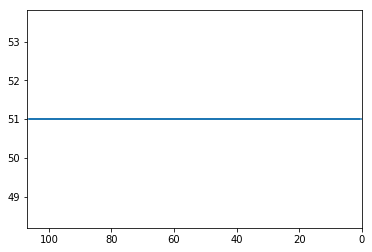

In [8]:
pd.Series(y_res).value_counts().plot();

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=.1, random_state=41)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4957, 36184), (551, 36184), (4957,), (551,))

In [10]:
y_train[:5]

array([ 22,  68, 106,   0,  42])

# X_train 2 iter 

In [11]:
# fit a logistic regression model to the data
model = LogisticRegression(multi_class='multinomial', max_iter=2, solver='sag', verbose=1)
model.fit(X_train, y_train)
print(model)

max_iter reached after 364 seconds
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=2, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=1, warm_start=False)


/home/adamszabunio/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.1min finished


In [13]:
model.score(X_train, y_train)

0.72886826709703445

In [14]:
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
train_confus_mat = metrics.confusion_matrix(expected, predicted)
print(train_confus_mat)

             precision    recall  f1-score   support

          0       0.86      0.76      0.81        41
          1       0.63      0.76      0.69        42
          2       0.79      0.74      0.76        46
          3       0.92      0.78      0.84        45
          4       0.86      0.84      0.85        50
          5       0.61      0.74      0.67        47
          6       0.87      0.77      0.81        43
          7       0.72      0.61      0.66        46
          8       0.84      0.60      0.70        45
          9       0.66      0.78      0.71        45
         10       0.62      0.73      0.67        45
         11       0.59      0.80      0.68        46
         12       0.84      0.65      0.73        48
         13       0.70      0.67      0.68        48
         14       0.75      0.59      0.66        46
         15       0.88      0.49      0.63        43
         16       0.91      0.71      0.80        45
         17       0.51      0.65      0.57   

# X_train 5 iter

In [17]:
# fit a logistic regression model to the data
model = LogisticRegression(multi_class='multinomial', max_iter=5, solver='sag', verbose=1)
model.fit(X_train, y_train)
print(model)

max_iter reached after 1095 seconds
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=5, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=1, warm_start=False)


/home/adamszabunio/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 18.3min finished


In [18]:
model.score(X_train, y_train)

0.95844260641517043

In [19]:
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
train_confus_mat = metrics.confusion_matrix(expected, predicted)
print(train_confus_mat)

             precision    recall  f1-score   support

          0       0.93      0.95      0.94        41
          1       0.95      1.00      0.98        42
          2       1.00      1.00      1.00        46
          3       1.00      1.00      1.00        45
          4       1.00      0.98      0.99        50
          5       0.98      0.96      0.97        47
          6       0.93      0.98      0.95        43
          7       1.00      0.93      0.97        46
          8       0.96      1.00      0.98        45
          9       0.93      0.89      0.91        45
         10       0.93      0.91      0.92        45
         11       0.79      0.91      0.85        46
         12       0.91      0.90      0.91        48
         13       0.98      0.94      0.96        48
         14       1.00      1.00      1.00        46
         15       0.96      1.00      0.98        43
         16       1.00      0.96      0.98        45
         17       0.93      0.93      0.93   

# X_train 10 iter

In [11]:
# fit a logistic regression model to the data
model = LogisticRegression(multi_class='multinomial', max_iter=10, solver='sag', verbose=1)
model.fit(X_train, y_train)
print(model)

max_iter reached after 1648 seconds
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=1, warm_start=False)


/home/adamszabunio/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/linear_model/sag.py:286: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 27.5min finished


In [13]:
model.score(X_train, y_train)

0.99798265079685289

In [12]:
# make predictions
expected = y_train
predicted = model.predict(X_train)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
train_confus_mat = metrics.confusion_matrix(expected, predicted)
print(train_confus_mat)

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        47
          1       1.00      1.00      1.00        49
          2       1.00      1.00      1.00        48
          3       1.00      0.98      0.99        44
          4       1.00      1.00      1.00        47
          5       1.00      1.00      1.00        45
          6       1.00      1.00      1.00        47
          7       1.00      1.00      1.00        47
          8       1.00      1.00      1.00        46
          9       1.00      1.00      1.00        46
         10       1.00      1.00      1.00        45
         11       1.00      0.98      0.99        47
         12       1.00      1.00      1.00        45
         13       1.00      1.00      1.00        45
         14       1.00      1.00      1.00        45
         15       0.98      1.00      0.99        45
         16       1.00      1.00      1.00        50
         17       1.00      1.00      1.00   

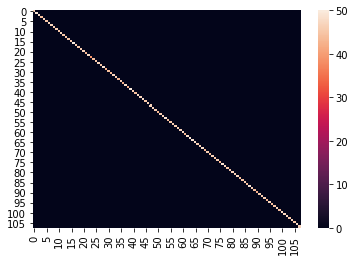

In [22]:
sns.heatmap(train_confus_mat);

# X_test 2 iter

In [15]:
model.score(X_test, y_test)

0.32304900181488205

In [16]:
expected1 = y_test
predicted1 = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected1, predicted1))
test_confus_mat = metrics.confusion_matrix(expected1, predicted1)
print(test_confus_mat)

             precision    recall  f1-score   support

          0       0.60      0.30      0.40        10
          1       0.57      0.44      0.50         9
          2       0.50      0.40      0.44         5
          3       0.50      0.33      0.40         6
          4       0.33      1.00      0.50         1
          5       0.13      0.50      0.21         4
          6       0.67      0.25      0.36         8
          7       0.14      0.20      0.17         5
          8       0.75      0.50      0.60         6
          9       0.18      0.33      0.24         6
         10       0.22      0.33      0.27         6
         11       0.25      0.40      0.31         5
         12       0.00      0.00      0.00         3
         13       0.00      0.00      0.00         3
         14       0.50      0.60      0.55         5
         15       0.67      0.50      0.57         8
         16       0.67      0.33      0.44         6
         17       0.00      0.00      0.00   

/home/adamszabunio/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# X_test 5 iter

In [20]:
model.score(X_test, y_test)

0.36297640653357532

In [21]:
expected1 = y_test
predicted1 = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected1, predicted1))
test_confus_mat = metrics.confusion_matrix(expected1, predicted1)
print(test_confus_mat)

             precision    recall  f1-score   support

          0       0.57      0.40      0.47        10
          1       0.80      0.44      0.57         9
          2       1.00      0.40      0.57         5
          3       0.50      0.50      0.50         6
          4       0.50      1.00      0.67         1
          5       0.25      0.50      0.33         4
          6       0.62      0.62      0.62         8
          7       0.33      0.40      0.36         5
          8       0.30      0.50      0.37         6
          9       0.20      0.17      0.18         6
         10       0.38      0.50      0.43         6
         11       0.20      0.40      0.27         5
         12       0.00      0.00      0.00         3
         13       0.00      0.00      0.00         3
         14       0.57      0.80      0.67         5
         15       0.60      0.75      0.67         8
         16       0.33      0.33      0.33         6
         17       0.00      0.00      0.00   

/home/adamszabunio/anaconda3/envs/dl/lib/python3.6/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# X_test 10 iter

In [ ]:
model.score(X_test, y_test)

In [15]:
expected1 = y_test
predicted1 = model.predict(X_test)
# summarize the fit of the model
print(metrics.classification_report(expected1, predicted1))
test_confus_mat = metrics.confusion_matrix(expected1, predicted1)
print(test_confus_mat)

             precision    recall  f1-score   support

          0       0.50      1.00      0.67         4
          1       0.20      0.50      0.29         2
          2       1.00      0.67      0.80         3
          3       0.86      0.86      0.86         7
          4       0.75      0.75      0.75         4
          5       0.25      0.17      0.20         6
          6       0.50      0.50      0.50         4
          7       0.00      0.00      0.00         4
          8       0.75      0.60      0.67         5
          9       0.50      0.20      0.29         5
         10       0.20      0.17      0.18         6
         11       0.00      0.00      0.00         4
         12       0.00      0.00      0.00         6
         13       0.33      0.17      0.22         6
         14       0.67      0.67      0.67         6
         15       0.50      0.17      0.25         6
         16       1.00      1.00      1.00         1
         17       0.67      0.80      0.73   

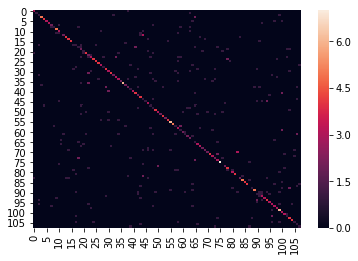

In [24]:
sns.heatmap(test_confus_mat);

____